In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
csv1 = "movie_data/movies.csv"
csv2 = "movie_data/ratings.csv"
csv3 = "movie_data/genome-scores.csv"
csv4 = "movie_data/genome-tags.csv"
csv5 = "movie_data/links.csv"
csv6 = "movie_data/tags.csv"

In [3]:
movies_df = pd.read_csv(csv1)
ratings_df = pd.read_csv(csv2)
genome_scores_df = pd.read_csv(csv3)
genome_tags_df = pd.read_csv(csv4)
links_df = pd.read_csv(csv5)
tags_df = pd.read_csv(csv6)

In [4]:
print(f'{len(movies_df)} movies')
print(f'{len(ratings_df)} ratings')

62423 movies
25000095 ratings


In [5]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [11]:
# filtering for the most relevant genome scores
relevant_genome_scores_df = genome_scores_df.loc[genome_scores_df['relevance'] > .85]

In [12]:
genome_tags_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [13]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
tags_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [26]:
# merging movies and ratings dataframes

new_df = ratings_df.merge(movies_df, how="inner")
new_df = new_df.drop(columns=['title', 'genres', 'timestamp'])
new_df.head()

,userId,movieId,rating
0,1,296,5.0
1,3,296,5.0
2,4,296,4.0
3,5,296,4.0
4,7,296,4.0


In [27]:
# applying 1's and 0's to rating column where the rating is greater or equal to 3.5 / 5 
# whether the reviewer liked the movie or not

new_df["rating"] = np.where(new_df["rating"] >= 3.5, 1, 0)

In [28]:
# data split into features and results for logistic regression

X = new_df.drop('rating', axis=1)
y = new_df['rating']

In [29]:
from sklearn import preprocessing
from sklearn import utils

#convert y values to categorical values
lab = preprocessing.LabelEncoder()
y_transformed = lab.fit_transform(y)

#view transformed values
print(y_transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, random_state=1)

[1 1 1 ... 1 1 1]


In [20]:
# fitting classifier to our model

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6251565127406717
Testing Data Score: 0.625341598688261


## Plots

In [30]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [31]:
# merging movie and ratings

movie_ratings = movies_df.merge(ratings_df, how="inner")
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0,890492517
...,...,...,...,...,...,...
25000090,209157,We (2018),Drama,119571,1.5,1574280748
25000091,209159,Window of the Soul (2001),Documentary,115835,3.0,1574280985
25000092,209163,Bad Poems (2018),Comedy|Drama,6964,4.5,1574284913
25000093,209169,A Girl Thing (2001),(no genres listed),119571,3.0,1574291826


In [32]:
# grabbing reduced sample, extracting year_released string from title

reduced = movie_ratings.sample(1000000)
reduced['year'] = reduced.title.str.extract('\((.*)\)')[0]

reduced['release_year'] = reduced['year'].str.split('(').str[-1]
reduced = reduced.drop(columns = ['year'])
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year
15371234,4370,A.I. Artificial Intelligence (2001),Adventure|Drama|Sci-Fi,84649,2.5,1533342912,2001
269488,19,Ace Ventura: When Nature Calls (1995),Comedy,132773,3.0,1110696758,1995
7913752,1387,Jaws (1975),Action|Horror,144859,5.0,1019606044,1975
12734397,3000,Princess Mononoke (Mononoke-hime) (1997),Action|Adventure|Animation|Drama|Fantasy,61227,3.5,1483959191,1997
10426918,2245,Working Girl (1988),Comedy|Drama|Romance,132267,5.0,1123479197,1988


In [34]:
# available genre categories

genres = ['Comedy','Adventure','Animation','Children','Fantasy','Romance','Drama',
          'Documentary','Action','Horror','Mystery','Sci-Fi','Western','Crime','Thriller',
          'Film-Noir','Musical','War']
print(len(genres))

18


In [41]:
# Function to sort dataframe by inputted genre

def genre_ratings(genre):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    return df

In [43]:
genre_ratings('Film-Noir').head()

,movieId,title,genres,userId,rating,timestamp,release_year
9948270,2066,Out of the Past (1947),Film-Noir,79983,4.0,975372064,1947
15768170,4848,Mulholland Drive (2001),Crime|Drama|Film-Noir|Mystery|Thriller,148960,4.5,1439810893,2001
7140656,1260,M (1931),Crime|Film-Noir|Thriller,34437,5.0,954393141,1931
19457879,32587,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller,53142,4.0,1120631763,2005
5141571,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery,66778,5.0,1225333812,1941


In [37]:
# Average rating for each genre

genre_averages = {
    'Genre': [],
    'Average Rating': []
}
for genre in genres:
    avg_rating = genre_ratings(genre)['rating'].mean()
    genre_averages['Genre'].append(genre)
    genre_averages['Average Rating'].append(avg_rating)

genre_avg_df = pd.DataFrame(genre_averages).sort_values('Average Rating', ascending=False)

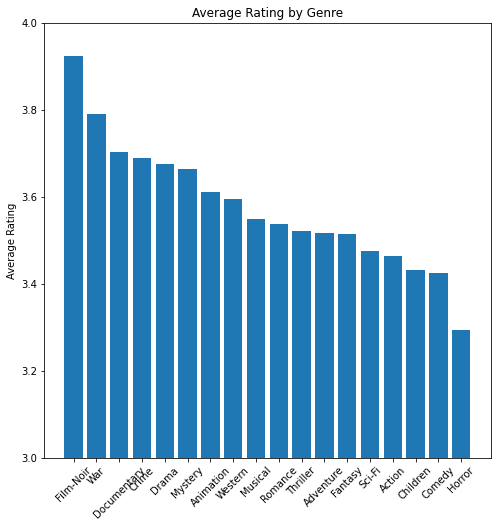

In [38]:
# Plotting average rating for each genre

plt.figure(figsize=(8, 8))
plt.bar(genre_avg_df['Genre'],genre_avg_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating by Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.savefig('images/avg_rating_by_genre.png')

In [44]:
# Function to grab average ratings for a given year and given genre

def ratings_by_year(genre, year):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    year_df = df.loc[df['release_year'] == year]
    avg_rating = year_df.groupby('release_year')['rating'].mean()
    return avg_rating[0]

In [40]:
ratings_by_year('Action','1995')

3.264095363946702

In [47]:
# Years 1993 - 2018, grabbing average rating for action movies (precursor to below function)

ratings_dict = {
    'Year': [],
    'Average Rating': []
}

years = ['1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006',
         '2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018']

for year in years:
    avg = ratings_by_year('Action',year)
    ratings_dict['Average Rating'].append(avg)
    ratings_dict['Year'].append(year)
    
ratings_dict_df = pd.DataFrame(ratings_dict)

In [48]:
ratings_dict_df.head()

,Year,Average Rating
0,1993,3.309020
1,1994,3.346206
2,1995,3.264095
3,1996,3.236629
4,1997,3.228559


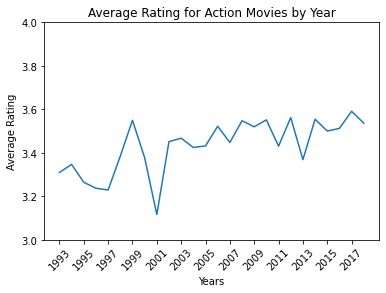

In [49]:
plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'])
plt.ylim(3, 4)
plt.title('Average Rating for Action Movies by Year')
plt.ylabel('Average Rating')
plt.xlabel('Years')

#every other year for xticks
labels = [n for n in ratings_dict_df['Year']][::2]
plt.xticks(labels,labels=labels,rotation=45)
plt.savefig('images/average_rating_action.png')

In [50]:
# function to produce plots for each inputted genre over the years

def plot_genre_by_year(genre):
    lower_genre = genre.lower()
    ratings_dict = {
        'Year': [],
        'Average Rating': []
    }

    # years list in string format
    years = ['19'+str(i) for i in range(60, 100)]+['200'+str(i) for i in range(0,10)]+['20'+str(i) for i in range(10,19)]

    year_labels = years[::4]

    for year in years:
        try:
            avg = ratings_by_year(genre,year)
            ratings_dict['Average Rating'].append(avg)
            ratings_dict['Year'].append(year)
        except:
            pass

    ratings_dict_df = pd.DataFrame(ratings_dict)

    ## Plot
    plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'], label=genre)
    plt.ylim(3, 5)
    plt.title(f'Average Rating for {genre} Movies by Year')
    plt.ylabel('Average Rating')
    plt.xlabel('Years')
    plt.xticks(year_labels,labels=year_labels,rotation=45)
    plt.savefig(f'images/avg_rating_by_year_{lower_genre}.png')
    plt.show()

In [51]:
def plot_genre_by_year_single_plot(genre):
    lower_genre = genre.lower()
    ratings_dict = {
        'Year': [],
        'Average Rating': []
    }

    years = ['19'+str(i) for i in range(60, 100)]+['200'+str(i) for i in range(0,10)]+['20'+str(i) for i in range(10,19)]

    year_labels = years[::4]

    for year in years:
        try:
            avg = ratings_by_year(genre,year)
            ratings_dict['Average Rating'].append(avg)
            ratings_dict['Year'].append(year)
        except:
            pass

    ratings_dict_df = pd.DataFrame(ratings_dict)

    ## Plot
    plt.plot(ratings_dict_df['Year'],ratings_dict_df['Average Rating'], label=genre)
    plt.ylim(3, 5)
    plt.title(f'Average Rating for all Genres by Year')
    plt.ylabel('Average Rating')
    plt.xlabel('Years')
    plt.xticks(year_labels,labels=year_labels,rotation=45)
    plt.legend(loc="upper right")
    plt.savefig(f'images/all_genre.png')
plt.show()

In [52]:
# list of top genres to make plots for

top_genres = ['War','Documentary','Crime','Drama','Mystery','Animation','Action']

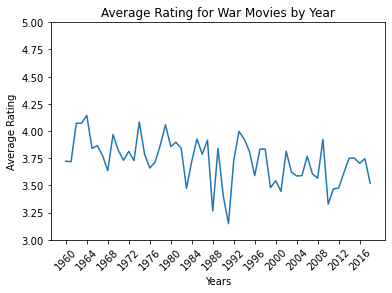

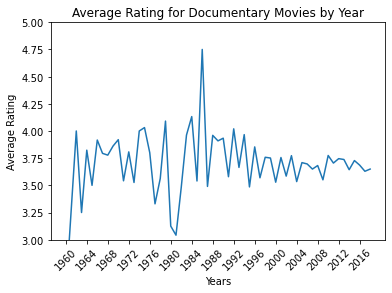

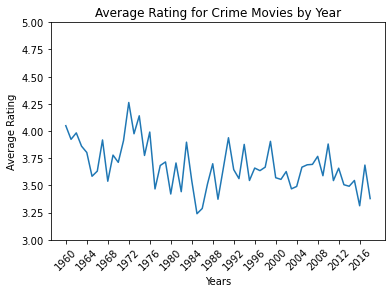

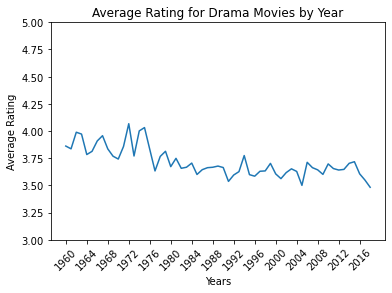

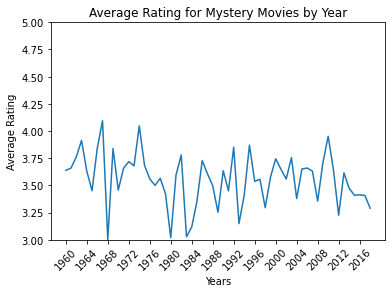

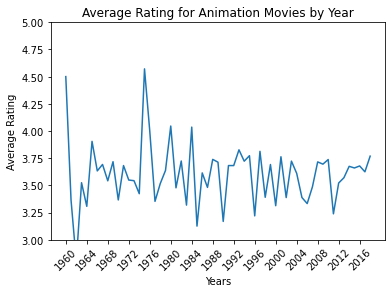

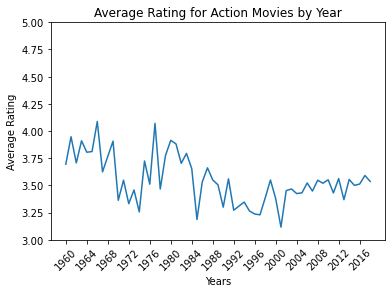

In [53]:
for genre in top_genres:
    plot_genre_by_year(genre)

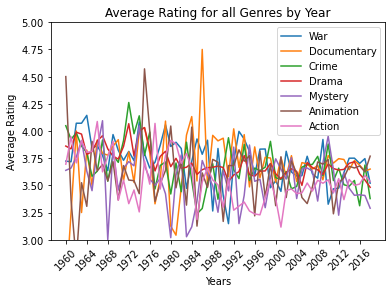

In [54]:
for genre in top_genres:
    plot_genre_by_year_single_plot(genre)

In [55]:
ratings_df.timestamp

0           1147880044
1           1147868817
2           1147868828
3           1147878820
4           1147868510
               ...    
25000090    1240953372
25000091    1240951998
25000092    1240950697
25000093    1240953434
25000094    1240952515
Name: timestamp, Length: 25000095, dtype: int64

In [56]:
# convert timestamp values to datetime to extract review_year

ratings_df['reviewDate'] = pd.to_datetime(ratings_df.timestamp, unit='s')

In [57]:
ratings_df['reviewYear'] = ratings_df.reviewDate.dt.year

In [59]:
# Getting date range, reviews start in 1995-2019
ratings_df.sort_values('reviewDate').head()

,userId,movieId,rating,timestamp,reviewDate,reviewYear
326761,2262,21,3.0,789652009,1995-01-09 11:46:49,1995
326810,2262,1079,3.0,789652009,1995-01-09 11:46:49,1995
326767,2262,47,5.0,789652009,1995-01-09 11:46:49,1995
15845015,102689,1,4.0,822873600,1996-01-29 00:00:00,1996
15845023,102689,39,5.0,822873600,1996-01-29 00:00:00,1996


In [61]:
# search cult classic movies to find movieId and build cc list below

movies_df.loc[movies_df.title.str.contains('Pulp Fiction')]

,movieId,title,genres
292,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


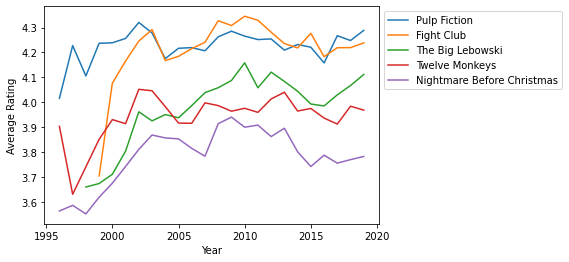

In [62]:
# Searching for cult classics to track ratings since release
# Plot ratings over the years since the movies release
# movieName, movieId

cult_classics = [['Pulp Fiction', 296], ['Fight Club', 2959], ['The Big Lebowski', 1732], 
                 ['Twelve Monkeys', 32], ['Nightmare Before Christmas', 551]]

for i, k in cult_classics:
    plt.plot(ratings_df.loc[ratings_df.movieId == k].groupby('reviewYear')['rating'].mean(), label=i)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.xlabel('Year')
    plt.ylabel('Average Rating')
    plt.savefig(f'images/cult_classics.png')

In [63]:
reduced = movie_ratings.sample(1000000)
reduced['year'] = reduced.title.str.extract('\((.*)\)')[0]

reduced['release_year'] = reduced['year'].str.split('(').str[-1]
reduced = reduced.drop(columns = ['year'])
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year
5221249,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,148905,5.0,1186672315,1950
695766,64,Two if by Sea (1996),Comedy|Romance,24097,3.5,1127094035,1996
14440400,3897,Almost Famous (2000),Drama,42835,5.0,1220127709,2000
18699100,8528,Dodgeball: A True Underdog Story (2004),Comedy,120783,2.0,1162494106,2004
17666588,6659,Tremors (1990),Comedy|Horror|Sci-Fi,29916,3.5,1108741050,1990


In [64]:
reduced.release_year.unique()

array(['1950', '1996', '2000', '2004', '1990', '1951', '1981', '1994',
       '1984', '1980', '2011', '1988', '1989', '2017', '2006', '2016',
       '2014', '1993', '2010', '1978', '1979', '2001', '2007', '1995',
       '2012', '1991', '1997', '1968', '2005', '1986', '1999', '1953',
       '2002', '1998', '1964', '2018', '2008', '1985', '1992', '1971',
       '1977', '2015', '1982', '1952', '1975', '2003', '1987', '1962',
       '1960', '1946', '1940', '1941', '2009', '1976', '2013', '1935',
       '1969', '1967', '1959', '1983', '1949', nan, '1958', '1965',
       '1933', '1961', '1972', '1955', '1954', '1942', '1931', '2019',
       '1944', '1973', '1963', '1966', '1974', '1938', '1945', '1922',
       '1939', '1970', '1927', '1928', '1947', '1957', '1943', '1948',
       '1956', '1932', '1937', '1934', '1917', '1936', '1921', '1894',
       '1930', '1925', '1924', '1906', '1912', '1926', '1929', '1920',
       '1923', '1901', '2006–2007', '1914', '1916', '1903', '1895',
       '1913

In [65]:
# cleaning release_year stringed data to convert to int
reduced = reduced[reduced['release_year'].str.contains('2006–2007')==False]
reduced = reduced[reduced['release_year'].str.contains('Close Relations')==False]
reduced = reduced[reduced['release_year'].str.contains('1983\)')==False]
reduced = reduced[reduced['release_year'].str.contains('Your Past Is Showing')==False]

reduced['reviewDate'] = pd.to_datetime(reduced.timestamp, unit='s')
reduced['reviewYear'] = reduced.reviewDate.dt.year

In [66]:
reduced.release_year = pd.to_numeric(reduced.release_year)

In [68]:
print(f'{len(reduced)} entries')

999566 entries


In [69]:
reduced.head()

,movieId,title,genres,userId,rating,timestamp,release_year,reviewDate,reviewYear
5221249,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance,148905,5.0,1186672315,1950,2007-08-09 15:11:55,2007
695766,64,Two if by Sea (1996),Comedy|Romance,24097,3.5,1127094035,1996,2005-09-19 01:40:35,2005
14440400,3897,Almost Famous (2000),Drama,42835,5.0,1220127709,2000,2008-08-30 20:21:49,2008
18699100,8528,Dodgeball: A True Underdog Story (2004),Comedy,120783,2.0,1162494106,2004,2006-11-02 19:01:46,2006
17666588,6659,Tremors (1990),Comedy|Horror|Sci-Fi,29916,3.5,1108741050,1990,2005-02-18 15:37:30,2005


In [70]:
# find average ratings for genres over the years, selecting for both reviewYear and release_year

def ratings_by_review_year(genre, year):
    df = reduced[reduced['genres'].str.contains(genre, regex=False)]
    year_df = df.loc[(df.reviewYear >= year) & (df.release_year >= year)]
    avg_rating = year_df.groupby('reviewYear')['rating'].mean()
    return avg_rating

In [71]:
# using above function to plot each genre

def plot_review_by_year(genres, year):
    titles = []
    for genre in genres:
        df = reduced[reduced['genres'].str.contains(genre, regex=False)]
        year_df = df.loc[df.reviewYear >= year]
        avg_rating = year_df.groupby('reviewYear')['rating'].mean()
        
        plt.plot(avg_rating, label=genre)
        plt.ylim(3.0,4.5)
        plt.xlabel("Year of Review")
        plt.ylabel("Average Rating")
        plt.xticks(range(year,2019)[::4])
        plt.legend(loc="upper right")
        titles.append(genre)
    plt.title(f'Movies by Review Year')
    plt.savefig(f'images/by_review_year/{titles[0]}-{titles[1]}')
    plt.show()

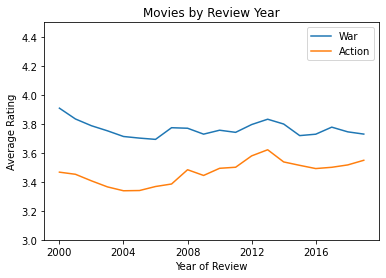

In [73]:
plot_review_by_year(['War','Action'], 2000)

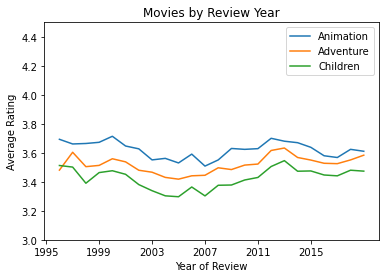

In [74]:
plot_review_by_year(['Animation','Adventure','Children'],1995)

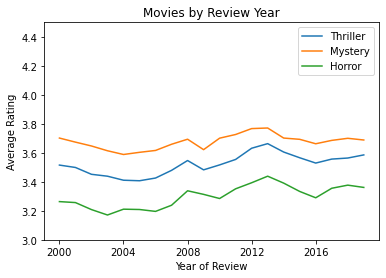

In [75]:
plot_review_by_year(['Thriller','Mystery','Horror'],2000)